In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
import uproot.models
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
sys.path.append(f'/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/Analysis/pida/')
from anatree_class import Anatree
from PIDA_class import PIDA
from  ana_tools import *


plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })



In [2]:
pid = PIDA("data/pida.root", entry_stop=None)

Loading single values


100%|██████████| 15/15 [00:01<00:00,  7.69it/s]


Done...
Loading vectors


100%|██████████| 38/38 [00:26<00:00,  1.44it/s]


Done
Loading planes


100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

Done
shape: (290_294, 15)
┌─────────┬────────┬───────┬─────────────┬───┬─────────────┬─────────────┬─────────────┬─────────┐
│ run     ┆ subrun ┆ event ┆ nuPDG_truth ┆ … ┆ recovtxx    ┆ recovtxy    ┆ recovtxz    ┆ ntracks │
│ ---     ┆ ---    ┆ ---   ┆ ---         ┆   ┆ ---         ┆ ---         ┆ ---         ┆ ---     │
│ i32     ┆ i32    ┆ i32   ┆ i32         ┆   ┆ f32         ┆ f32         ┆ f32         ┆ i32     │
╞═════════╪════════╪═══════╪═════════════╪═══╪═════════════╪═════════════╪═════════════╪═════════╡
│ 1498    ┆ 1      ┆ 46401 ┆ -14         ┆ … ┆ 38.493984   ┆ 139.025085  ┆ 624.799622  ┆ 1       │
│ 1498    ┆ 1      ┆ 46403 ┆ 12          ┆ … ┆ 157.950912  ┆ -474.461273 ┆ 664.447449  ┆ 1       │
│ 1498    ┆ 1      ┆ 46404 ┆ 14          ┆ … ┆ -198.674728 ┆ -346.991241 ┆ 235.861801  ┆ 3       │
│ 1498    ┆ 1      ┆ 46405 ┆ 14          ┆ … ┆ 25.805025   ┆ 4.681137    ┆ 332.119171  ┆ 4       │
│ 1498    ┆ 1      ┆ 46406 ┆ 14          ┆ … ┆ 236.066696  ┆ -166.304016 ┆ 918.5603

In [5]:
dfs:pl.DataFrame
dfv:pl.DataFrame
df:pl.DataFrame

dfs = pid.dfsingles
dfv = pid.dfvector
dfp = pid.dfplanes

df = dfs.join(dfv, on=selection_events())
df = df.join(dfp, on=selection_events())

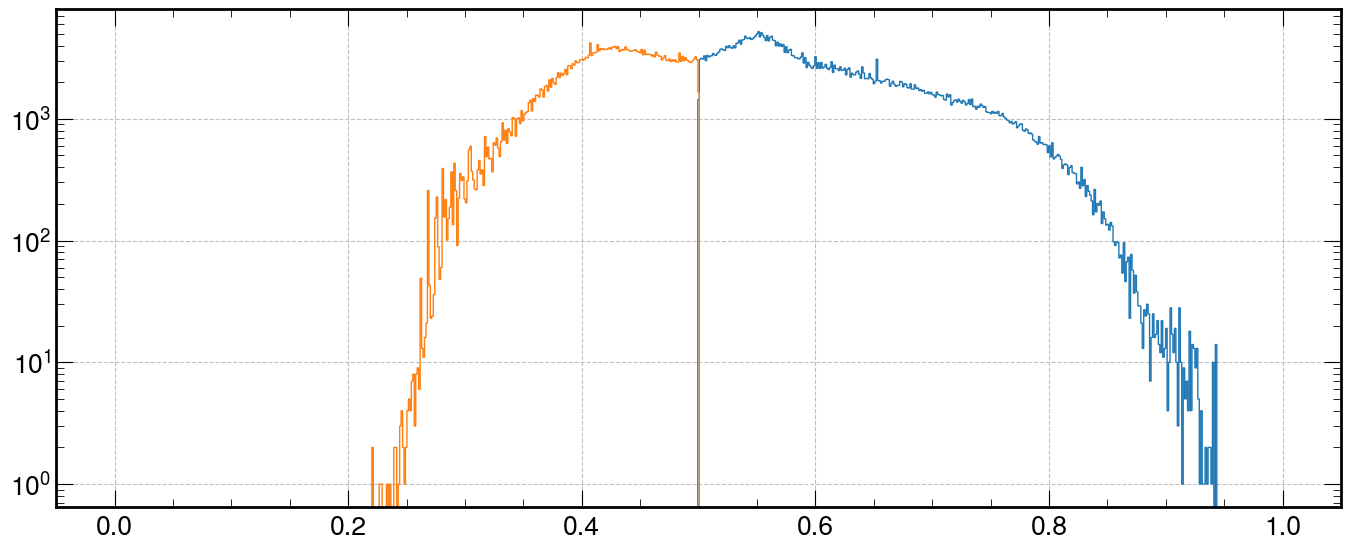

In [6]:
plt.hist(df.filter(pl.col('trkPFPIsTrack'))['trkPFPScoreIsTrack'], histtype='step', bins=np.linspace(0,1,800))
plt.hist(df.filter(~pl.col('trkPFPIsTrack'))['trkPFPScoreIsTrack'], histtype='step', bins=np.linspace(0,1,800))
plt.yscale('log')

In [31]:
xmin = -363.3766
ymin = -607.8299
zmin = -0.876256
xmax = 363.37
ymax = 607.82
zmax = 1393.4
threshold = 5

dftrkg4 = df.with_columns(
    trkIsContained2 = pl.when(
        (pl.col('trkendx') - (xmin+threshold) >= 0) &
        (pl.col('trkendy') - (ymin+threshold) >= 0) &
        (pl.col('trkendz') - (zmin+threshold) >= 0) &
        (pl.col('trkendx') - (xmax-threshold) <= 0) &
        (pl.col('trkendy') - (ymax-threshold) <= 0) &
        (pl.col('trkendz') - (zmax-threshold) <= 0) 
    ).then(True).otherwise(False)
    ).filter(
    pl.col('trkPFPIsTrack'),
    # pl.col('trklen') > 20,
    # pl.col('trkIsContained')
    # (pl.col('trkg4pdg').abs() == 13) |
    # (pl.col('trkg4pdg').abs() == 2212) |
    # (pl.col('trkg4pdg').abs() == 211) 
)

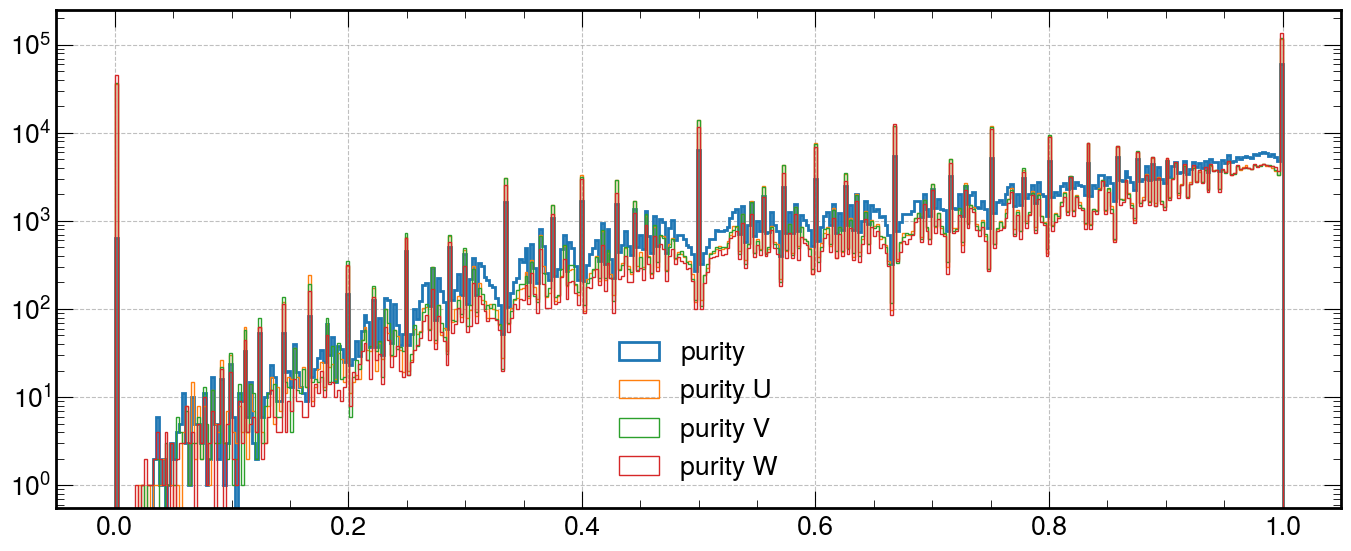

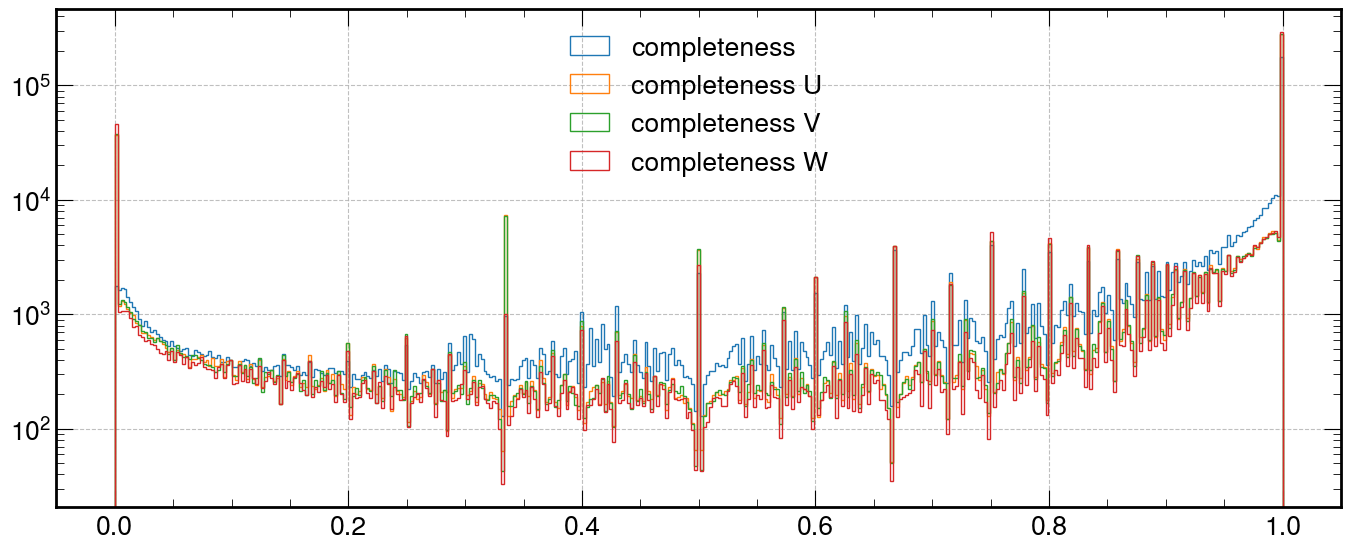

In [32]:
binsp = np.linspace(0,1,400)
plt.hist(dftrkg4['trkpurity'],          histtype='step', bins=binsp, label='purity', lw=2);
plt.hist(dftrkg4['trkpurity_planes_U'], histtype='step', bins=binsp, label='purity U');
plt.hist(dftrkg4['trkpurity_planes_V'], histtype='step', bins=binsp, label='purity V');
plt.hist(dftrkg4['trkpurity_planes_W'], histtype='step', bins=binsp, label='purity W');
plt.yscale('log')
plt.legend()
# plt.xlim(0.4,0.7)


plt.figure()
plt.hist(dftrkg4['trkcompleteness'], histtype='step', bins=binsp, label='completeness');
plt.hist(dftrkg4['trkcompleteness_planes_U'], histtype='step', bins=binsp, label='completeness U');
plt.hist(dftrkg4['trkcompleteness_planes_V'], histtype='step', bins=binsp, label='completeness V');
plt.hist(dftrkg4['trkcompleteness_planes_W'], histtype='step', bins=binsp, label='completeness W');
plt.yscale('log')
plt.legend()

In [25]:
test = dftrkg4.with_columns(
    g4idB = pl.when(pl.col('trkbestplane')==0).then(pl.col('trkg4id_planes_U')).otherwise(
            pl.when(pl.col('trkbestplane')==1).then(pl.col('trkg4id_planes_V')).otherwise(
            pl.when(pl.col('trkbestplane')==2).then(pl.col('trkg4id_planes_W')).otherwise(
            -1
    )))
)['trkg4id', 'g4idB']

len(np.where((test['g4idB'] != test['trkg4id']).to_numpy())[0])

23807

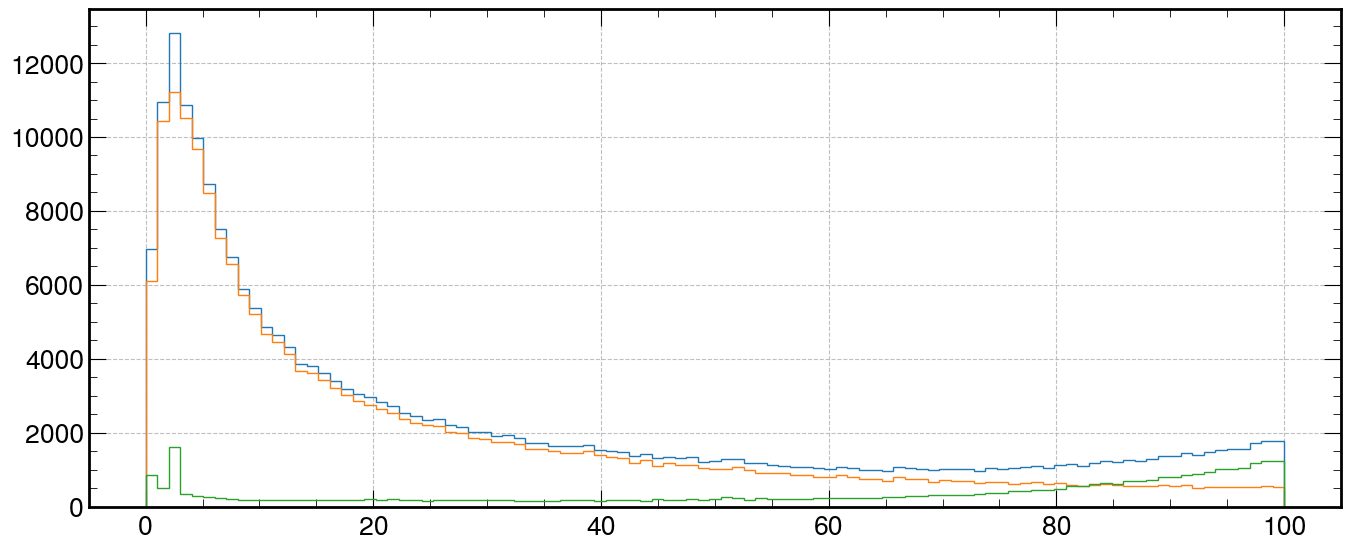

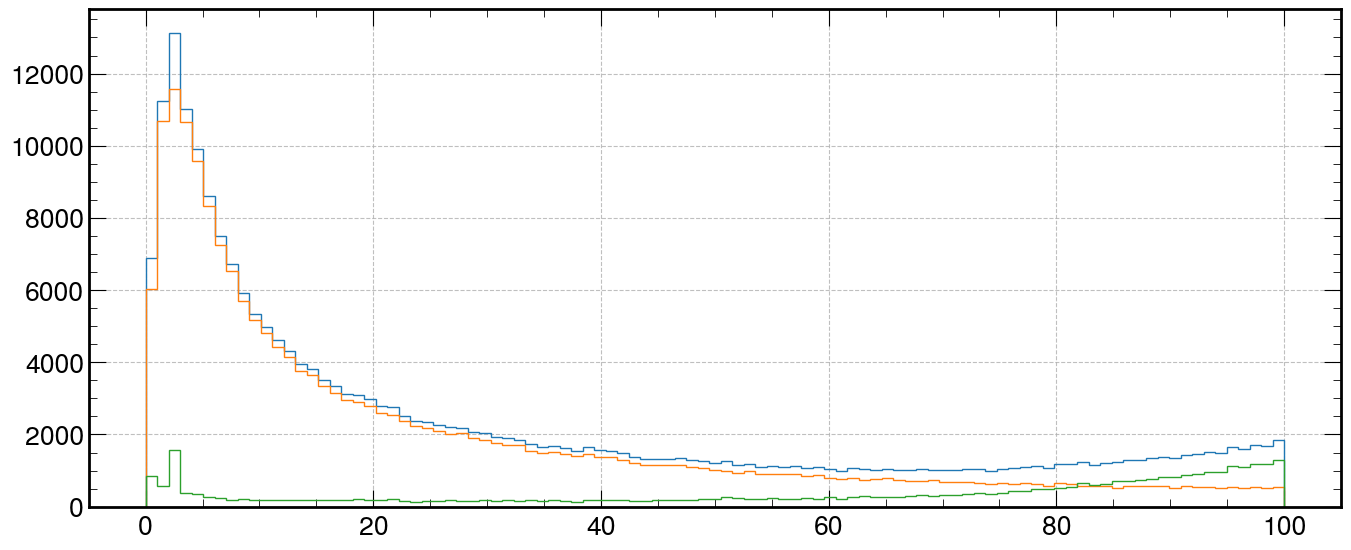

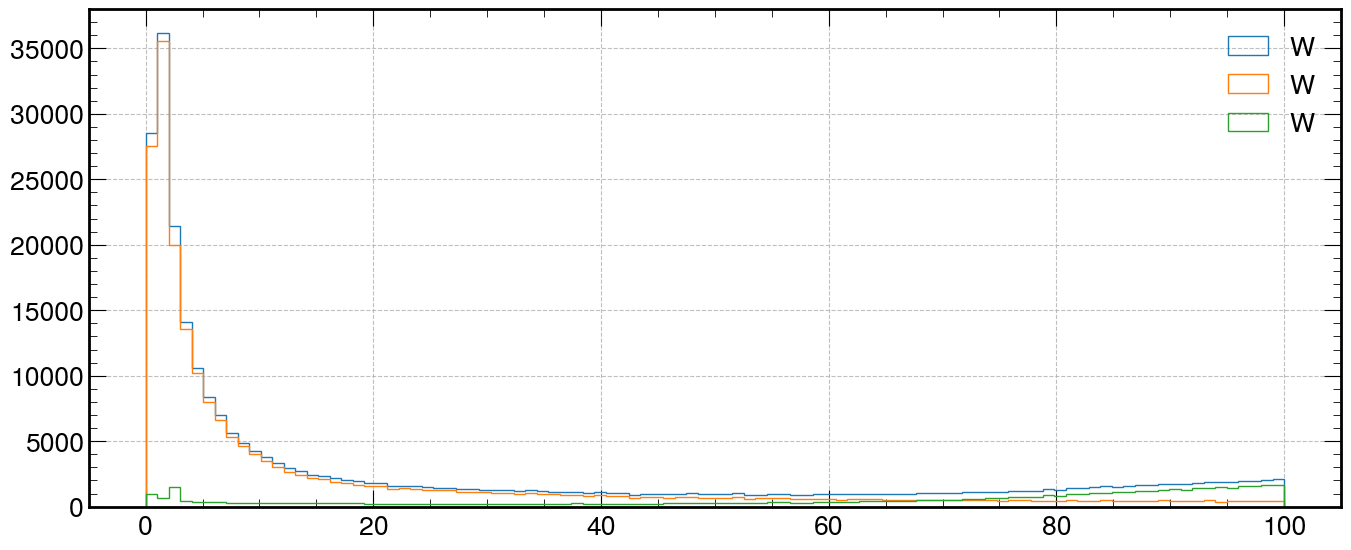

In [26]:
binschi2 = np.linspace(0,100,100)
plt.figure()
plt.hist(df['trkpidchi2pr_U'], bins=binschi2, histtype='step', label='U');
plt.hist(df.filter(pl.col('trkg4pdg_planes_U').abs()==2212)['trkpidchi2pr_U'], bins=binschi2, histtype='step', label='U');
plt.hist(df.filter(pl.col('trkg4pdg_planes_U').abs()!=2212)['trkpidchi2pr_U'], bins=binschi2, histtype='step', label='U');
plt.figure()
plt.hist(df['trkpidchi2pr_V'], bins=binschi2, histtype='step', label='V');
plt.hist(df.filter(pl.col('trkg4pdg_planes_V').abs()==2212)['trkpidchi2pr_V'], bins=binschi2, histtype='step', label='V');
plt.hist(df.filter(pl.col('trkg4pdg_planes_V').abs()!=2212)['trkpidchi2pr_V'], bins=binschi2, histtype='step', label='V');
plt.figure()
plt.hist(df['trkpidchi2pr_W'], bins=binschi2, histtype='step', label='W');
plt.hist(df.filter(pl.col('trkg4pdg_planes_W').abs()==2212)['trkpidchi2pr_W'], bins=binschi2, histtype='step', label='W');
plt.hist(df.filter(pl.col('trkg4pdg_planes_W').abs()!=2212)['trkpidchi2pr_W'], bins=binschi2, histtype='step', label='W');
plt.legend()

In [27]:
def getbestof(df:pl.DataFrame, var:str) -> pl.DataFrame:
    df = df.with_columns(
        pl.when(
            (pl.col('trkpidndf_W') >= pl.col('trkpidndf_V')) & 
            (pl.col('trkpidndf_W') >= pl.col('trkpidndf_U'))  
            ).then(
                pl.col(f'{var}_W')
            ).otherwise(
                pl.when(
                    (pl.col('trkpidndf_V') >= pl.col('trkpidndf_U'))  
                ).then(
                    pl.col(f'{var}_V')
                ).otherwise(
                    pl.col(f'{var}_U')
                )
            ).alias(f"{var}_B")
    )
    return df

allkeys = dftrkg4.columns
allkeys = [ k.strip("_U") for k in allkeys if "_U" in k]
for k in allkeys:
    dftrkg4 = getbestof(dftrkg4, k)
dftrkg4

run,subrun,event,nuPDG_truth,ccnc_truth,mode_truth,nuWeight_truth,enu_truth,vtxx_truth,vtxy_truth,vtxz_truth,recovtxx,recovtxy,recovtxz,ntracks,trkId,trkstartx,trkstarty,trkstartz,trkendx,trkendy,trkendz,trkpurity,trkcompleteness,trkg4id,trkg4pdg,trkg4en,trkg4mass,trkg4origin,trknhits,trkg4id_planes_U,trkg4id_planes_V,trkg4id_planes_W,trkg4pdg_planes_U,trkg4pdg_planes_V,trkg4pdg_planes_W,trkg4en_planes_U,…,trkpidchi2ka_U,trkpidchi2ka_V,trkpidchi2ka_W,trkpidchi2pi_U,trkpidchi2pi_V,trkpidchi2pi_W,trkpidchi2mu_U,trkpidchi2mu_V,trkpidchi2mu_W,trkpidpida_U,trkpidpida_V,trkpidpida_W,allcalo_planes_U,allcalo_planes_V,allcalo_planes_W,nallhits_planes_U,nallhits_planes_V,nallhits_planes_W,trkIsContained2,trkg4id_planes_B,trkg4pdg_planes_B,trkg4en_planes_B,trkg4mass_planes_B,trkg4origin_planes_B,trkpurity_planes_B,trkcompleteness_planes_B,trknhits_planes_B,trknhitsmatch_planes_B,trkcalo_planes_B,trkpidndf_B,trkpidchi2pr_B,trkpidchi2ka_B,trkpidchi2pi_B,trkpidchi2mu_B,trkpidpida_B,allcalo_planes_B,nallhits_planes_B
i32,i32,i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,bool,i32,i32,f32,f32,i32,f32,f32,i32,i32,f32,i32,f32,f32,f32,f32,f32,f32,i32
1498,1,46404,14,0,2,3.9511076e7,4.898662,-198.489304,-347.402039,235.702194,-198.674728,-346.991241,235.861801,3,1,-208.475586,-334.402344,235.602356,-263.144165,-195.866241,223.753189,0.937192,0.930318,5,22,1.000143,0.0,1,812,5,5,5,22,22,22,1.000143,…,215.131271,113.308365,128.508102,63.430382,31.879574,32.914185,44.680035,21.509748,20.98341,1.810646,4.998029,6.380779,1.685614,1.658041,1.851254,964,726,701,true,5,22,1.000143,0.0,1,0.949254,0.924419,335,318,0.717135,46,424.498047,113.308365,31.879574,21.509748,4.998029,1.658041,726
1498,1,46405,14,1,1,3.7592644e7,0.71368,27.603746,6.772283,338.971161,25.805025,4.681137,332.119171,4,0,26.090801,4.487493,331.651459,24.700939,2.350056,323.415405,0.985507,0.62963,5,22,0.133332,0.0,1,69,5,5,5,22,22,22,0.133332,…,59.166595,47.18808,45.765545,39.412243,44.00423,48.005505,42.852642,47.826225,45.648098,14.994554,22.575027,21.688469,0.16015,0.155261,0.194537,89,94,78,true,5,22,0.133332,0.0,1,1.0,0.625,25,25,0.069018,17,55.816429,47.18808,44.00423,47.826225,22.575027,0.155261,94
1498,1,46405,14,1,1,3.7592644e7,0.71368,27.603746,6.772283,338.971161,25.805025,4.681137,332.119171,4,1,-36.333416,-3.634556,334.778015,-44.738373,-4.256458,334.532288,1.0,0.488722,4,22,0.100026,0.0,1,65,4,4,4,22,22,22,0.100026,…,225.344116,189.40654,206.121841,53.68145,59.197659,66.675568,41.879871,43.841614,46.030159,0.672741,0.420735,0.546215,0.16015,0.155261,0.194537,89,94,78,true,4,22,0.100026,0.0,1,1.0,0.468085,22,22,0.037261,13,329.695099,189.40654,59.197659,43.841614,0.420735,0.155261,94
1498,1,46405,14,1,1,3.7592644e7,0.71368,27.603746,6.772283,338.971161,25.805025,4.681137,332.119171,4,2,-76.922195,-8.033392,334.288513,-80.810844,-5.172719,334.131042,1.0,0.300752,4,22,0.100026,0.0,1,40,4,4,4,22,22,22,0.100026,…,139.27475,156.171814,204.791397,35.196838,47.555531,62.045486,23.68606,33.241009,41.107162,2.375053,1.407419,0.496425,0.16015,0.155261,0.194537,89,94,78,true,4,22,0.100026,0.0,1,1.0,0.254902,13,13,0.030586,9,269.031067,139.27475,35.196838,23.68606,2.375053,0.16015,89
1498,1,46406,14,1,2,3.5645856e7,5.525855,236.063629,-165.661331,918.63269,236.066696,-166.304016,918.560364,7,2,225.790085,-175.898697,930.690918,208.713821,-185.599945,942.019287,0.91018,0.571429,3201,22,0.213593,0.0,1,167,3201,3201,3201,22,22,22,0.213593,…,41.584576,152.6483,66.876907,12.094961,45.624592,29.213514,10.611641,34.330414,29.343023,8.101315,4.298802,10.890573,1.399773,1.41865,1.611198,801,738,625,true,3201,22,0.213593,0.0,1,0.9375,0.759494,64,60,0.147235,41,288.266571,152.6483,45.624592,34.330414,4.298802,1.41865,738
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,

In [28]:
filter_min_purity = dftrkg4.group_by(selection_events()).agg(
    pl.col('trkpurity').min(),
    pl.col('trkpurity_planes_U').min(),
    pl.col('trkpurity_planes_V').min(),
    pl.col('trkpurity_planes_W').min(),
    pl.col('trkpurity_planes_B').min(),
)
filter_min_purity = filter_min_purity.filter(
    pl.col('trkpurity_planes_B') > 0.9
).select(selection_events())

df_min_purity = dftrkg4.join(filter_min_purity, on=selection_events())

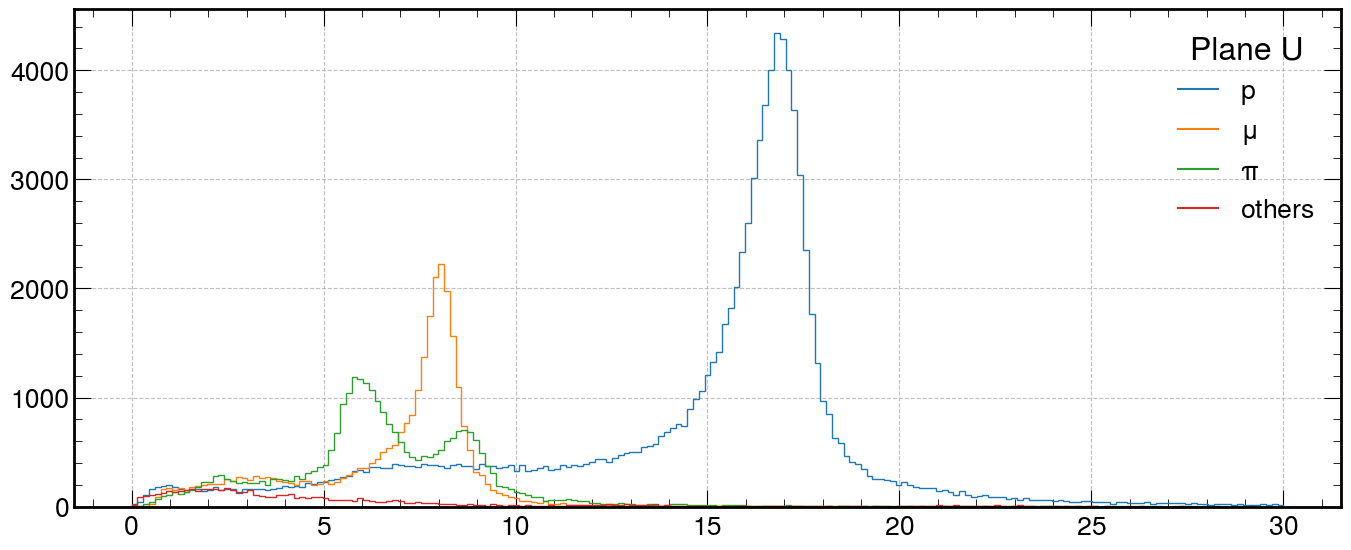

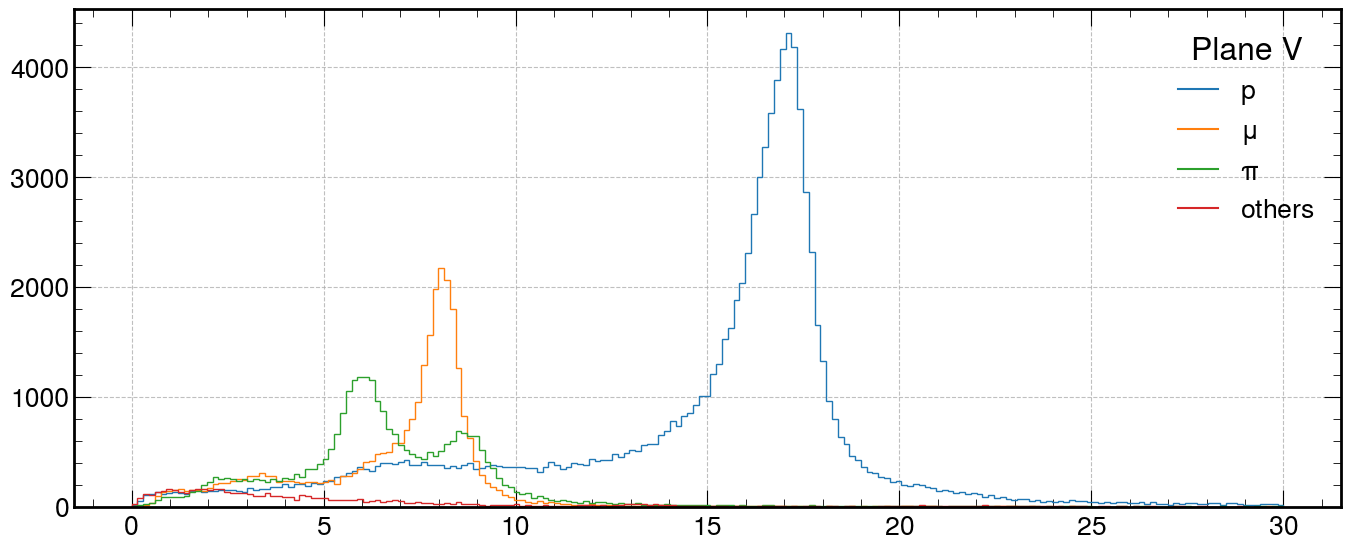

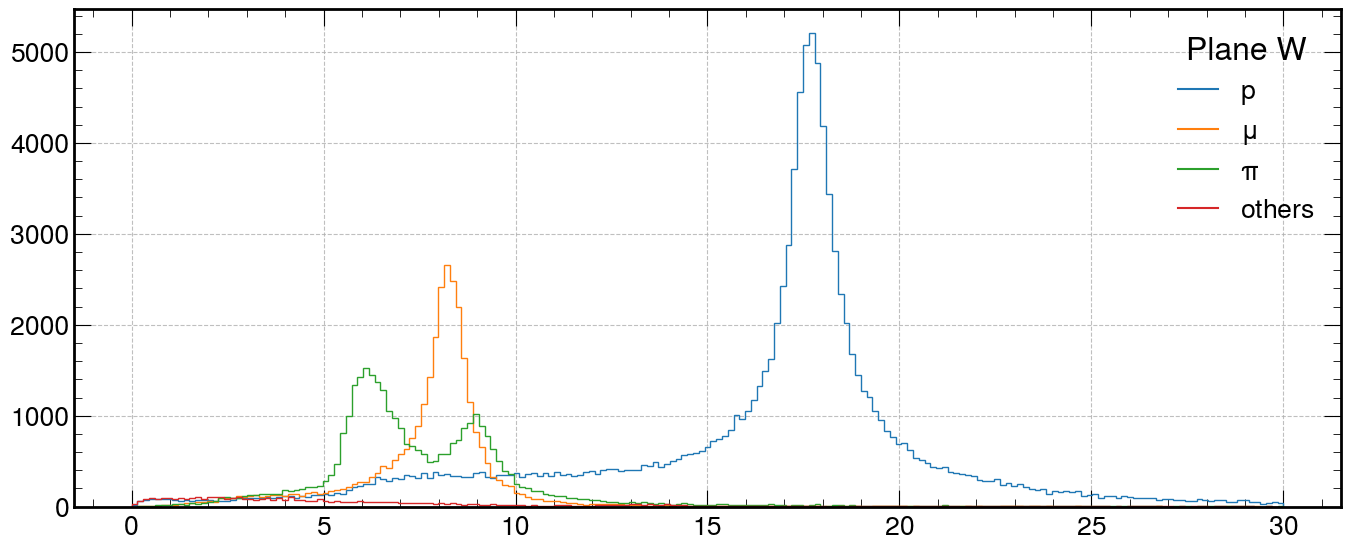

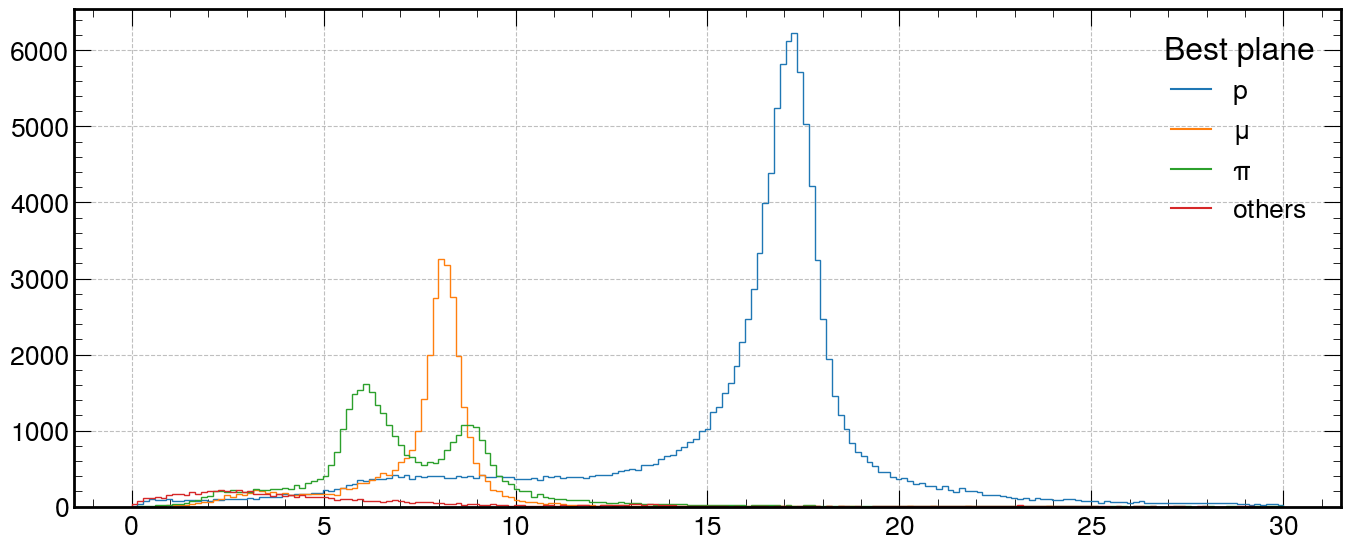

In [33]:

from matplotlib.lines import Line2D
def plot_pid(df:pl.DataFrame, plane="W", pdg=2212, binspid = np.linspace(0,30,200), notthispdg=False):
    title = f'Plane {plane}'
    if plane=="B":
        df = getbestof(df, 'trkg4pdg_planes')
        df = getbestof(df, 'trkpidpida')
        df = getbestof(df, 'trkpurity_planes')
        df = getbestof(df, 'trkcompleteness_planes')
        title = 'Best plane'

    trkpdg = f"trkg4pdg_planes_{plane}"
    pida = f"trkpidpida_{plane}"
    if (pdg != -1):
        if (notthispdg):
            df = df.filter(pl.col(trkpdg).abs()!=pdg)
        else:
            df = df.filter(pl.col(trkpdg).abs()==pdg)
        particlename = particle.Particle.from_pdgid(pdg).latex_name
        particlename = particlename.strip("^{+}")
        particlename = particlename.strip("^{-}")
    else:
        df = df.filter(
            pl.col(trkpdg).abs()!=2212,
            pl.col(trkpdg).abs()!=211,
            pl.col(trkpdg).abs()!=13,
        )
        particlename='others'
        
    df = df.filter(
        pl.col(f'trkpurity_planes_{plane}') > 0.85,
        pl.col(f'trkcompleteness_planes_{plane}') > 0.85,
        pl.col(f'trkIsContained')
    )
    label = r'${{{}}}$'.format(particlename)
    if notthispdg:
        label = r'not ${{{}}}$'.format(particlename)
        
    plt.hist(df[pida], binspid, histtype='step',label=label)
    # Create new legend handles but use the colors from the existing ones
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    
    plt.legend(title = title, handles=new_handles, labels=labels)
    return

plot_pid(dftrkg4, 'U', pdg=2212)
plot_pid(dftrkg4, 'U', pdg=13)
plot_pid(dftrkg4, 'U', pdg=211)
plot_pid(dftrkg4, 'U', pdg=-1)
plt.figure()
plot_pid(dftrkg4, 'V', pdg=2212)
plot_pid(dftrkg4, 'V', pdg=13)
plot_pid(dftrkg4, 'V', pdg=211)
plot_pid(dftrkg4, 'V', pdg=-1)
plt.figure()
plot_pid(dftrkg4, 'W', pdg=2212)
plot_pid(dftrkg4, 'W', pdg=13)
plot_pid(dftrkg4, 'W', pdg=211)
plot_pid(dftrkg4, 'W', pdg=-1)
plt.figure()
plot_pid(dftrkg4, 'B', pdg=2212)
plot_pid(dftrkg4, 'B', pdg=13)
plot_pid(dftrkg4, 'B', pdg=211)
plot_pid(dftrkg4, 'B', pdg=-1)

70224 12528 0.1513921113689095


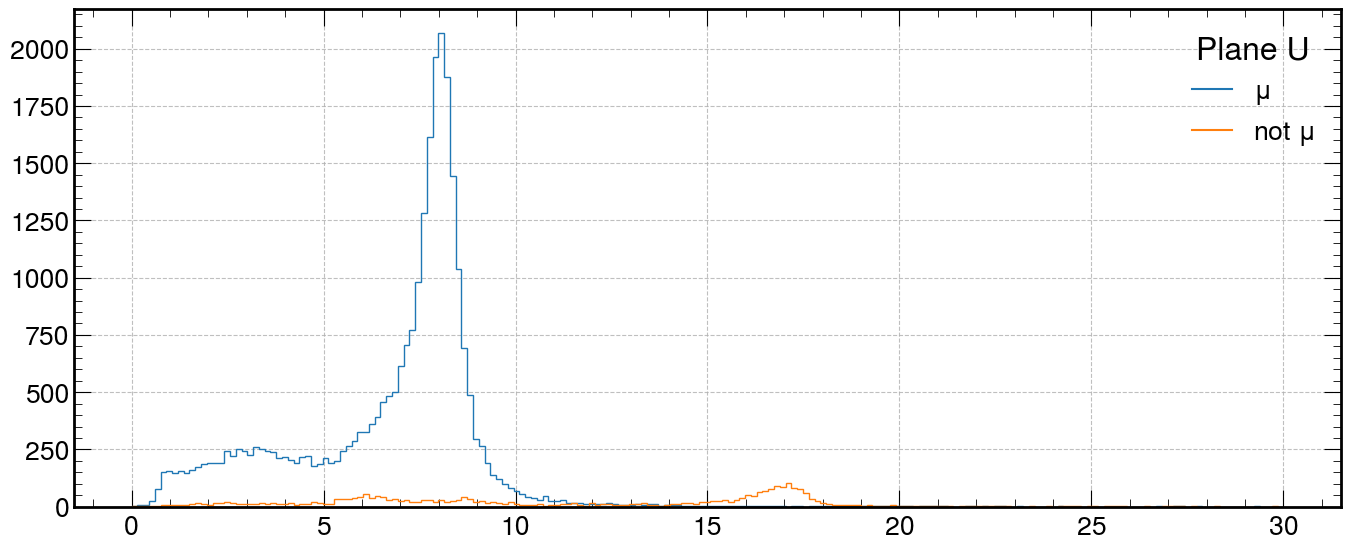

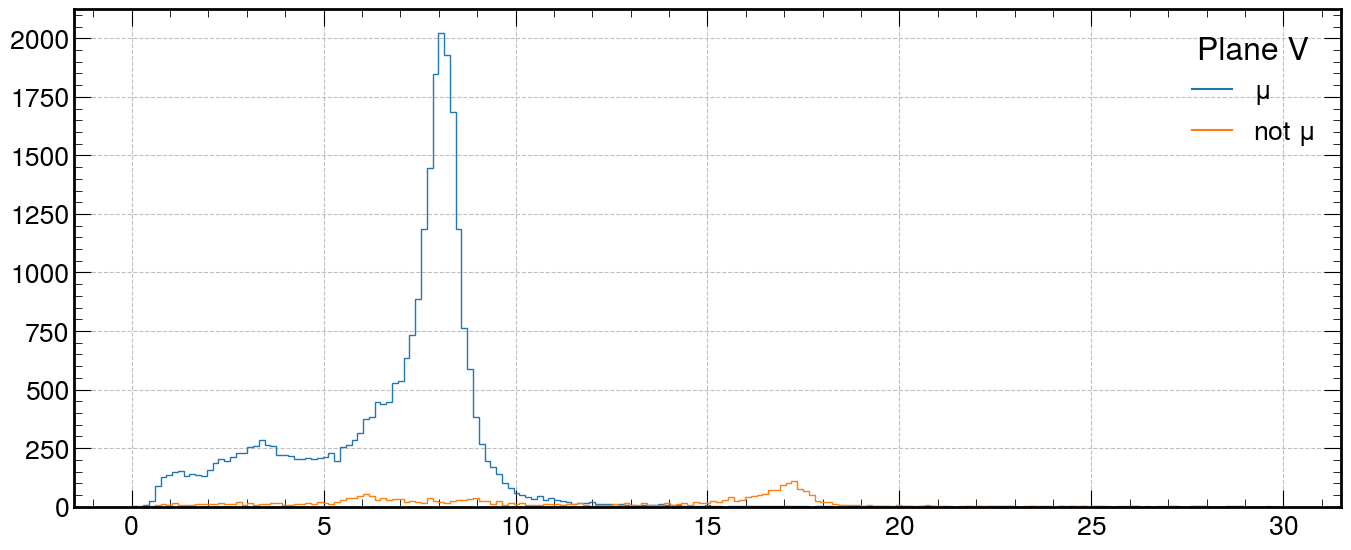

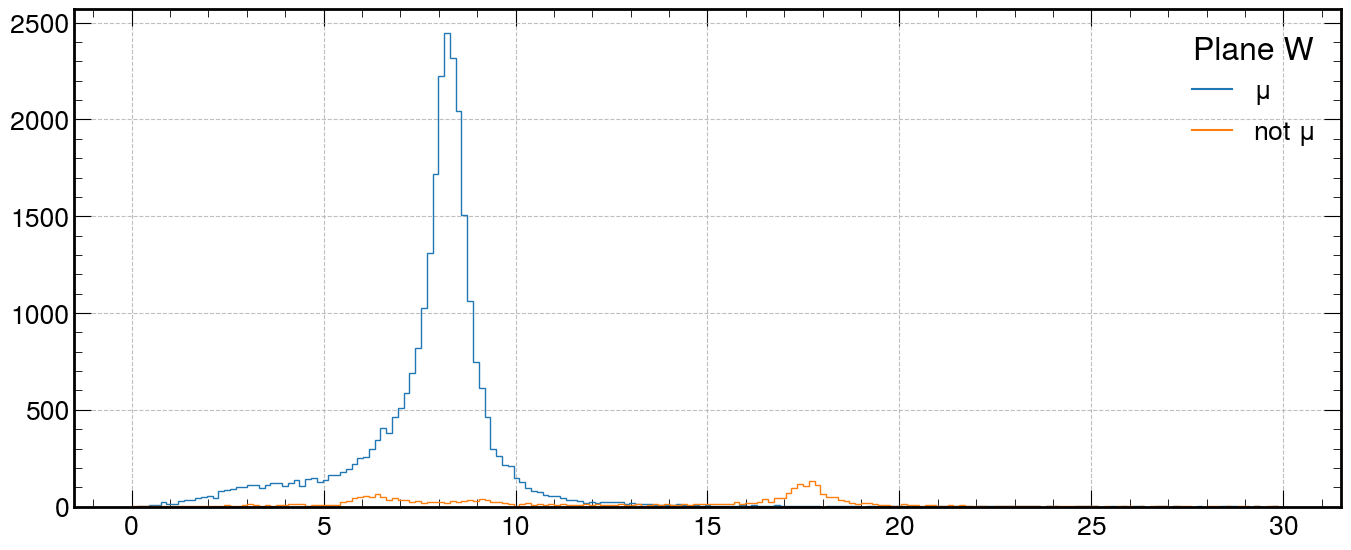

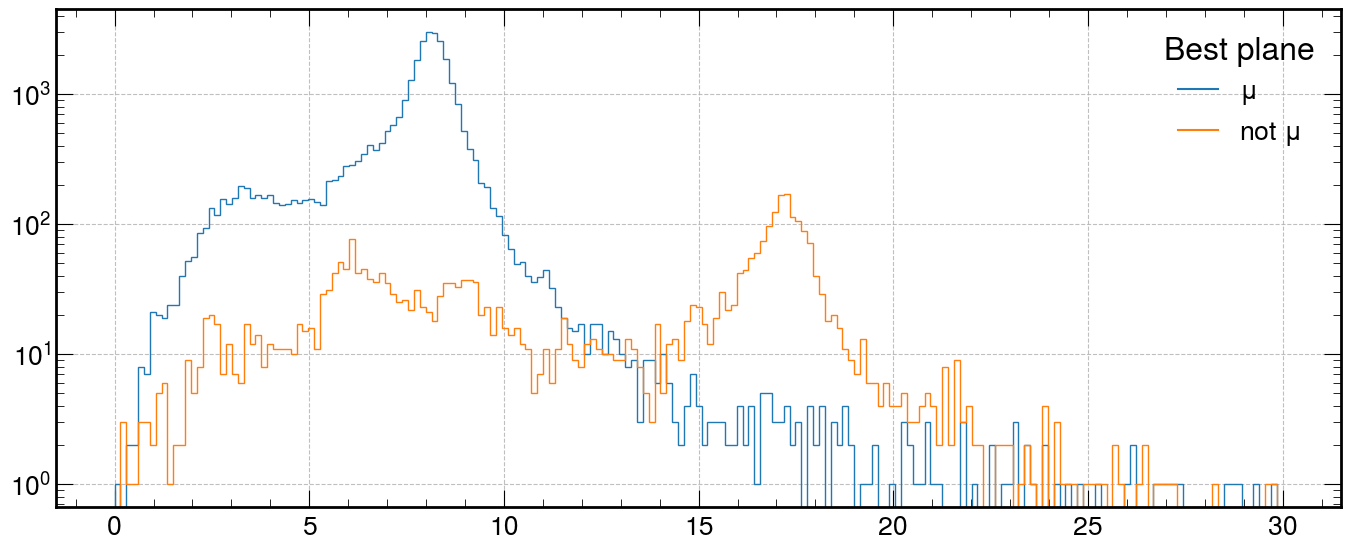

In [133]:
dfallmu = dftrkg4.sort('trklen').filter(
    pl.col('ccnc_truth') == 0,
    pl.col('nuPDG_truth').abs() == 14
)
dfmucandidate = dfallmu.sort('trklen').filter(
    pl.col('trklen') < 2e3,
).group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)
notmu = len(dfmucandidate.filter(
    pl.col('trkg4pdg_planes_W').abs() != 13
))
mu = len(dfmucandidate.filter(
    pl.col('trkg4pdg_planes_W').abs() == 13
))

dfallmu = dfallmu.group_by(selection_events(), maintain_order=True).agg(
    pl.all().last()
)
print(mu, notmu, notmu/(mu+notmu))
plot_pid(dfmucandidate, 'U', pdg=13)
plot_pid(dfmucandidate, 'U', pdg=13, notthispdg=True)
plt.figure()
plot_pid(dfmucandidate, 'V', pdg=13)
plot_pid(dfmucandidate, 'V', pdg=13, notthispdg=True)
plt.figure()
plot_pid(dfmucandidate, 'W', pdg=13)
plot_pid(dfmucandidate, 'W', pdg=13, notthispdg=True)
plt.figure()
plot_pid(dfmucandidate, 'B', pdg=13)
plot_pid(dfmucandidate, 'B', pdg=13, notthispdg=True)

plt.yscale('log')

/home/henrique/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning:

Glyph 9 (	) missing from current font.

/home/henrique/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 9 (	) missing from current font.



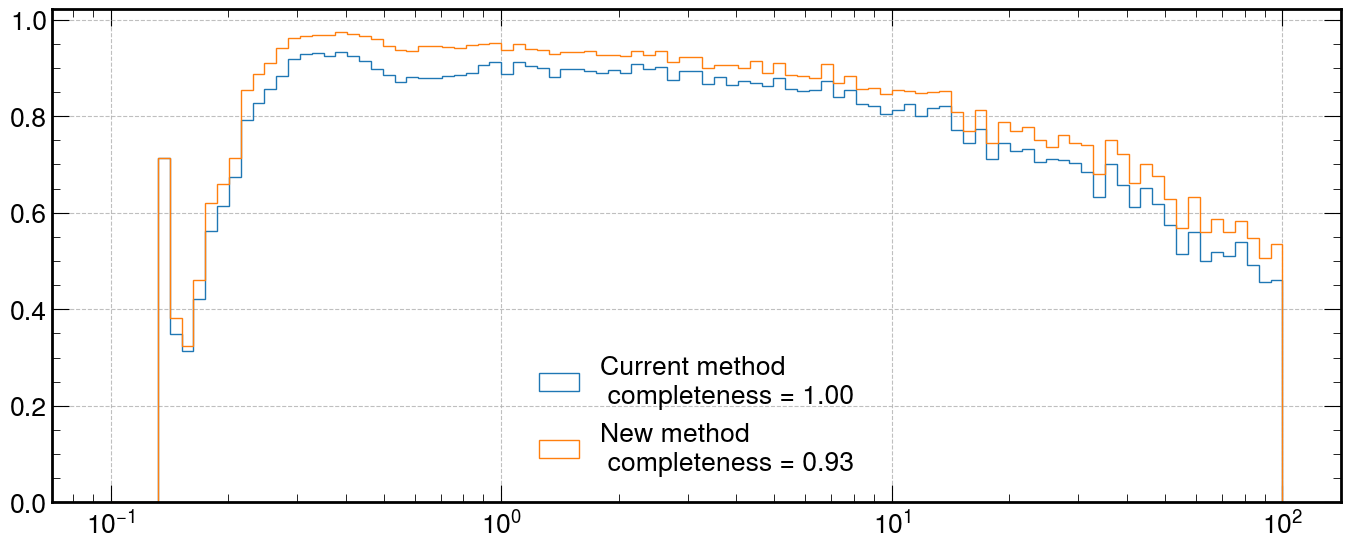

<Figure size 1400x600 with 0 Axes>

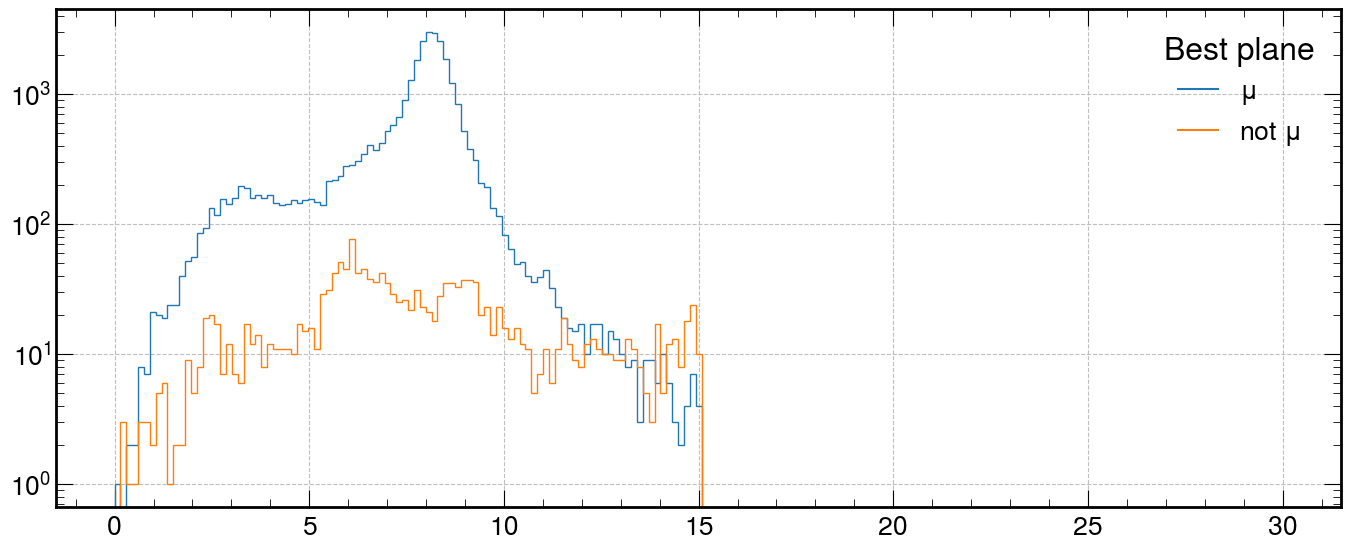

In [132]:
from typing import List
dfallmu = getbestof(dfallmu, "trkpidpida")
dfallmu = getbestof(dfallmu, "trkg4pdg_planes")
# I tried 1e3 cut, virtually no change...
def create_mucandidates(df, cut=2e3):
    df = df.sort('trklen').filter(
        pl.col('trklen') < cut,
    ).group_by(selection_events(), maintain_order=True).agg(
        pl.all().last()
    )
    df = getbestof(df, "trkpidpida")
    df = getbestof(df, "trkg4pdg_planes")
    dfismu = df.filter(
        pl.col('trkg4pdg_planes_B').abs() == 13
    )
    return df, dfismu


def create_mucandidates_2(df, cut=2e3, pidacut=15):
    df = df.sort('trklen').filter(
        pl.col('trklen') < cut,
    )
    df = getbestof(df, "trkpidpida")
    df = getbestof(df, "trkg4pdg_planes")
    df = df.filter(
        pl.col('trkpidpida_B') < pidacut,
    ).group_by(selection_events(), maintain_order=True).agg(
        pl.all().last()
    )
    dfismu = df.filter(
        pl.col('trkg4pdg_planes_B').abs() == 13
    )
    return df, dfismu
def plot_purity(df, dffiltered, dfall, binse=None, label=None):
    if not binse:
        binse = np.logspace(-1,2, 100)
    bn, b = np.histogram(df['enu_truth'], bins=binse)
    bnfiltered, b = np.histogram(dffiltered['enu_truth'], bins=binse)
    # plt.hist(b[:-1], b, weights=bn, histtype='step');

    completeness = len(df['enu_truth'])/len(dfall['enu_truth'])
    if label:
        label += f"\n\tcompleteness = {completeness:.2f}"
    purity = np.divide(bnfiltered, bn, out=np.zeros_like(bn, dtype=np.float64), where=bn!=0)
    plt.hist(b[:-1], b, weights=purity, histtype='step', label=label);
    plt.legend()
# plt.hist(b[:-1], b, weights=completeness, histtype='step');
dfmucandidate, dfmucandidate_ismu = create_mucandidates(dfallmu)
dfmucandidate2, dfmucandidate_ismu2 = create_mucandidates_2(dfallmu)

plot_purity(dfmucandidate, dfmucandidate_ismu, dfallmu, label="Current method")
plot_purity(dfmucandidate2, dfmucandidate_ismu2, dfallmu, label="New method")
plt.xscale('log')
plt.figure()

plt.figure()
plot_pid(dfmucandidate2, 'B', pdg=13)
plot_pid(dfmucandidate2, 'B', pdg=13, notthispdg=True)
plt.yscale('log')

In [14]:
particle.Particle.from_pdgid(13).latex_name

'\\mu^{-}'

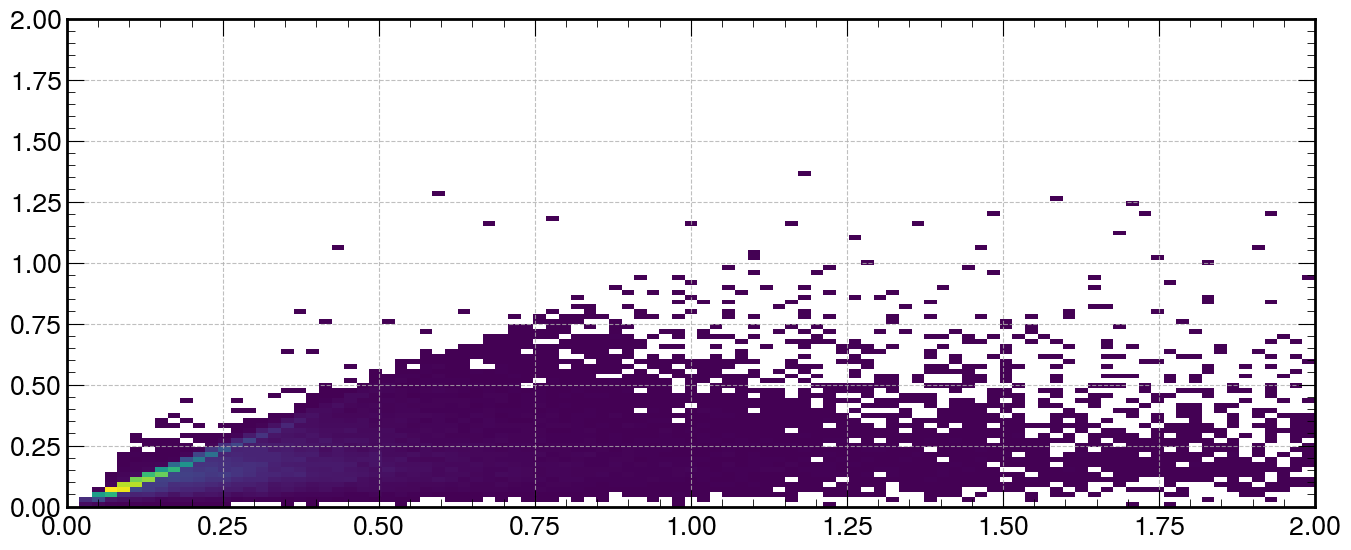

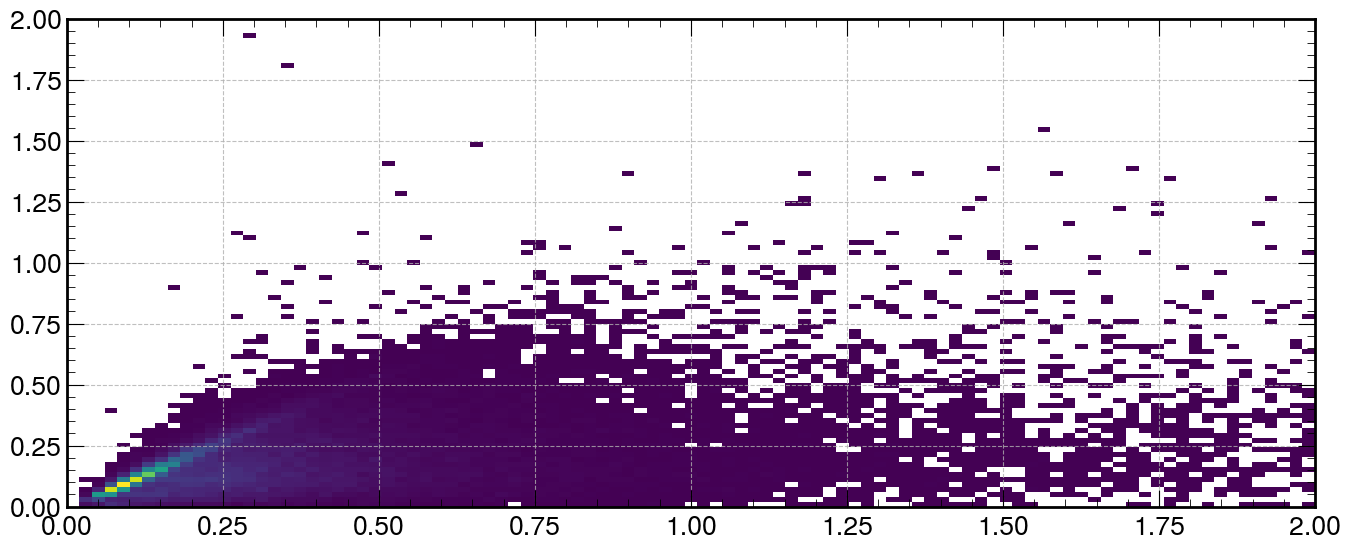

In [17]:
dfmu = dftrkg4.sort('trklen').filter(
    pl.col('trkg4pdg').abs()==211,
    pl.col('trkpurity') > 0.8,
    pl.col('trkcompleteness') > 0.8,
).group_by(selection_events(), maintain_order=True).agg(
    pl.all().first()
# ).filter(
    # pl.col('trkg4origin') == 1,
    # pl.col('nuPDG_truth').abs()==13,
)

binse = np.logspace(-1,2,200)
binse = np.linspace(0,2,100)
plt.hist2d(dfmu['trkg4en']-0.140, np.sqrt(dfmu['trkmomrange_mu']**2+0.105**2)-0.105, bins=[binse, binse], cmin=1);
# plt.xscale('log')
# plt.yscale('log')
plt.figure()
plt.hist2d(dfmu['trkg4en']-0.140, dfmu['trkcalo_planes_W'], bins=[binse, binse], cmin=1);

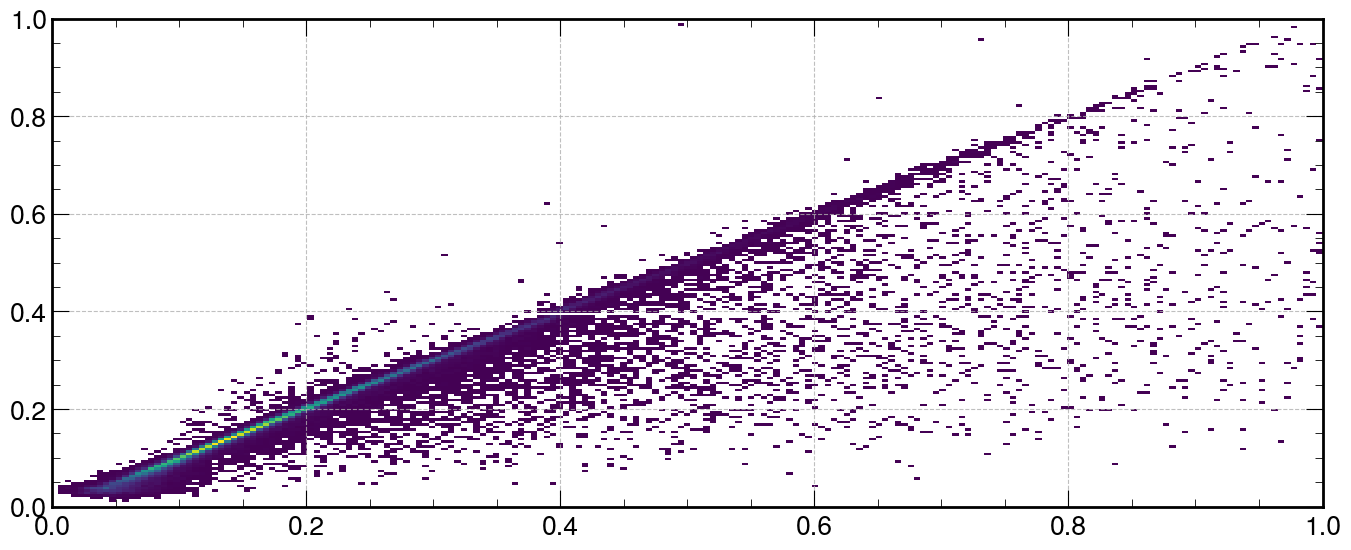

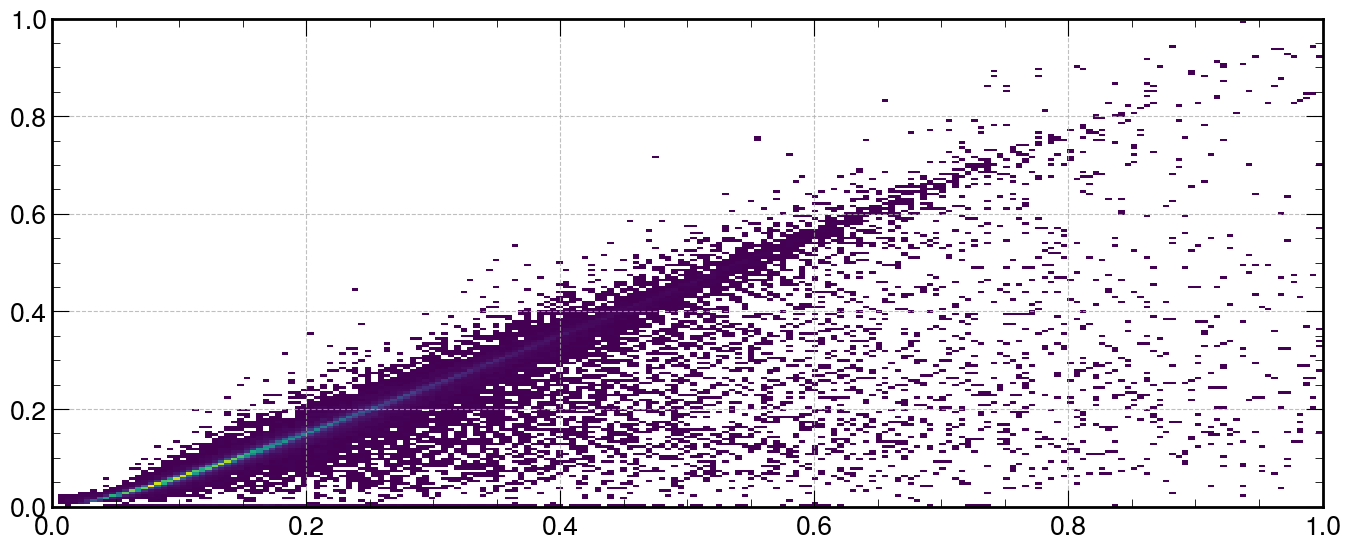

In [42]:
dfpr = dftrkg4.sort('trklen').filter(
    pl.col('trkg4pdg').abs()==2212,
    pl.col('trkpurity') > 0.9,
    pl.col('trkcompleteness') > 0.9,
).group_by(selection_events(), maintain_order=True).agg(
    pl.all().first()
)

binse=np.linspace(0,1,200)
plt.hist2d(dfpr['trkg4en']-0.9383, np.sqrt(dfpr['trkmomrange_pr']**2+0.9383**2)-0.9383, bins=[binse, binse], cmin=1);
plt.figure()
plt.hist2d(dfpr['trkg4en']-0.9383, dfpr['trkcalo_planes_W'], bins=[binse, binse], cmin=1);